In [148]:
import nltk
import numpy as np
import pandas as pd
import pickle
import stocker
import re
import spacy
import string
import seaborn as sns
import en_core_web_sm
from spacy.tokens import DocBin
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import en_core_web_lg

In [149]:
train=pd.read_csv('train.csv')
price=train.iloc[:,:1]
train.drop(['price'],axis=1,inplace=True)
train['created_at']=pd.to_datetime(train['created_at']).dt.date
print(train.shape)
train=train[(train['is_retweet']==False) & (train['favorite_count']>0)]
print(train.shape)
print(train.head())

(4939, 5)
(3182, 5)
   created_at                                               text  \
0  2019-01-01  Gas prices are low and expected to go down thi...   
3  2019-01-01  Washington Examiner - “MAGA list: 205 ‘histori...   
4  2019-01-01  One thing has now been proven. The Democrats d...   
5  2019-01-01  “General” McChrystal got fired like a dog by O...   
6  2019-01-01  “Kim Jong Un says North Korea will not make or...   

   retweet_count  favorite_count  is_retweet  
0          30080          201811       False  
3          17196           77877       False  
4          26840          119139       False  
5          16907           69306       False  
6          24747          116495       False  


In [150]:
train['created_at'].value_counts()

2019-01-14    136
2019-01-11    120
2019-01-18    117
2019-01-12    117
2019-01-22    108
             ... 
2020-01-14     10
2020-01-15     10
2020-01-05      6
2020-01-01      6
2020-01-08      2
Name: created_at, Length: 62, dtype: int64

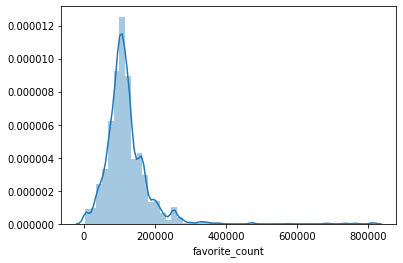

In [151]:
sns.distplot(train['favorite_count'])

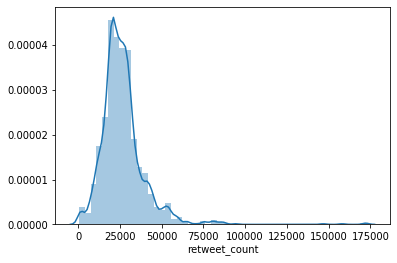

In [152]:
sns.distplot(train['retweet_count'])

In [153]:
train['importance']=(train['retweet_count']+train['favorite_count'])/2
train.drop(['retweet_count','favorite_count','is_retweet'],axis=1,inplace=True)
train['text']=train['text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]).str.replace('[{}]'.format(string.punctuation), '')
train=train[train['text']!=""]
train=train.groupby(['created_at']).apply(lambda x: x.nlargest(1,['importance'])).reset_index(drop=True)
train.drop(['importance'],axis=1,inplace=True)
print(train.head())

   created_at                                               text
0  2019-01-01  Congratulations to President \r\nJairBolsonaro...
1  2019-01-02  Here we go with Mitt Romney but so fast Questi...
2  2019-01-03  Sadly there can be no REAL Border Security wit...
3  2019-01-04  How do you impeach a president who has won per...
4  2019-01-05  The Democrats want Billions of Dollars for For...


In [158]:
nlp = spacy.load("en_core_web_lg", disable=['parser', 'tagger', 'ner'])
stops = spacy.lang.en.stop_words.STOP_WORDS
def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)
train['text']=train['text'].apply(normalize, lowercase=True, remove_stopwords=True)
nlp = spacy.load('en_core_web_lg')
cleaning= list(nlp.pipe(train['text'],n_threads=2))
train['text']=pd.Series(cleaning)
train['score']=pd.Series([doc.vector_norm for doc in cleaning])
train.head()

,created_at,text,score
0,2019-01-01,"(congratulation, president, jairbolsonaro, gre...",3.277248
1,2019-01-02,"(mitt, romney, fast, question, flake, hope, pr...",3.296245
2,2019-01-03,"(sadly, real, border, security, wall)",4.059332
3,2019-01-04,"(impeach, president, win, great, election, tim...",3.155623
4,2019-01-05,"(democrat, want, billion, dollar, foreign, aid...",3.565881


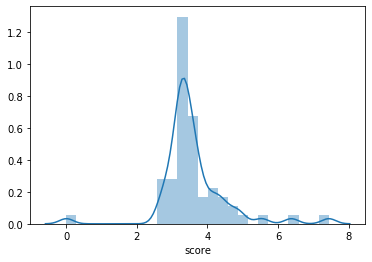

In [159]:
sns.distplot(train['score'])